# Den&egrave;ve-Machens spiking reservoirs in Rockpool

**Published articles describing this approach**

* **Boerlin et al.** 2013. _Predictive coding of dynamical variables in balanced spiking networks_. Plos Comp. Biol. **9** _11_. DOI:[10.1371/journal.pcbi.1003258](http://doi.org/10.1371/journal.pcbi.1003258)
* **Denève and Machens** 2016. _Efficient codes and balanced networks_. Nat. Neurosci. **19** _3_. DOI:[10.1038/nn.4243](http://doi.org/10.1038/nn.4243)

**Housekeeping and import statements**

In [1]:
# - Disable warning display
import warnings
warnings.filterwarnings('ignore')

# Import required modules and configure
from rockpool import TSContinuous
from rockpool.networks import NetworkDeneve
from rockpool.layers import RecFSSpikeEulerBT
from rockpool.timeseries import set_global_ts_plotting_backend

import numpy as np
from scipy.integrate import solve_ivp

# - Use matplotlib for plotting
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

## Basic overview of model
A spiking network is designed to approximate a pre-defined dynamical system

$\mathbf{\dot{x}} = \mathbf{A}\mathbf{x} + \mathbf{c}(t)$

where $\mathbf{x}$ is a vector of $J$ dynamical variables evolving under the transformations in the $J\times J$ matrix $\mathbf{A}$, and under the $J\times 1$ time-varying command variables $\mathbf{c}(t)$.

The network of $N$ spiking neurons produces a set of $N$ spike trains $\mathbf{o}(t)$. The firing rates $\mathbf{r}(t)$ of the neurons are estimated by an exponential window such that

$\mathbf{\dot r}/\lambda_d + \mathbf{r} = \mathbf{o}(t)$

We define a $J\times N$ matrix $\mathbf{\Gamma}$, which act as decoding weights from the spiking neurons and the dynamical variables $\mathbf{x}$. The network then produces an estimate $\mathbf{\hat{x}}$ of the dynamical variables:

$\mathbf{\dot{\hat{x}}}=-\lambda_d \mathbf{\hat{x}} + \mathbf{\Gamma o}(t)$

Here $\lambda_d$ is a decay rate of the output decoder.

This scheme implies that we have a set of exponential synapses on the output, with time constants roughly $1/\lambda_d$, that integrate reservoir spikes through the synaptic weights $\mathbf{\Gamma}$ to produce the output estimate $\mathbf{\hat{x}}$.

The output weights $\mathbf{\Gamma}$ are _fixed_ under this scheme; we need to determine the appropriate recurrent reservoir weights that ensure the decoding is accurate.

Den&egrave;ve et al. assume that the spikes of the system are placed to minimise the error between the desired output $\mathbf{x}$ and the estimate $\mathbf{\hat x}$. They provide two cost parameters $\nu$ and $\mu$, which contribute to the error through linear and quadratic terms given by

$\nu ||\mathbf{r}||_1$, and

$\mu ||\mathbf{r}||^2_2$

The parameter $\nu$ therefore penalises the overall firing rates, and $\mu$ penalises the uneven distribution of spiking. The full cost function minimised by the system is

$E(t) = \int_0^t \textrm{d}u \left( ||\mathbf{x}(u) - \mathbf{\hat x}(u)|| \right) + \nu ||\mathbf{r}||_1 + \mu ||\mathbf{r}||^2_2$

### Network dynamics and recurrent weights
Neurons in the network approximate a standard leaky integrate-and-fire model, under the membrane potential dynamics

$\mathbf{\dot V} + \lambda_V \mathbf{V} = - \mathbf{\Omega}^f \mathbf{o}(t) + 1/\lambda_d \mathbf{\Omega}^s\mathbf{r}(t) + \mathbf{\Gamma}^T\mathbf{c}(t) + \sigma_V\eta(t)$

$V_i(t) > T_i \rightarrow \textrm{spike}$

where $T_i$ is the firing threshold for the neuron $i$, given by

$T_i = ( \nu\lambda_d + \mu \lambda_d^2 + || \mathbf{\Gamma}_i||^2 )/2$

The noise term $\sigma_V\eta(t)$ injects Gaussian-distributed noise with std. dev. $\sigma_V$ at each time step.

The recurrent weights consist of a fast (instantaneous) inhibitory component $\mathbf{\Omega}^f$, which includes a self-reset; and a slow excitatory component $\mathbf{\Omega}^s$. These weights are derived from the decoder weights $\mathbf{\Gamma}$ and the dynamics $\mathbf{A}$ of the system that should be approximated:

$\mathbf{\Omega}^f = \mathbf{\Gamma}^T\mathbf{\Gamma} + \mu\lambda_d^2\mathbf{I}$

$\mathbf{\Omega}^s = \mathbf{\Gamma}^T(\mathbf{A} + \lambda_d\mathbf{I})\mathbf{\Gamma}$

### Neural integrator
Let's begin by defining the simplest possible system: a leaky integrator where $\mathbf{\dot x} = -\lambda_s\mathbf{x} + \mathbf{c}(t)$. In other words, $\mathbf{A} = -\lambda_s\mathbf{I}$, and the system will simply integrate the command signal $\mathbf{c}(t)$ with a leak. We'll randomly define the output weights $\mathbf{\Gamma}$.

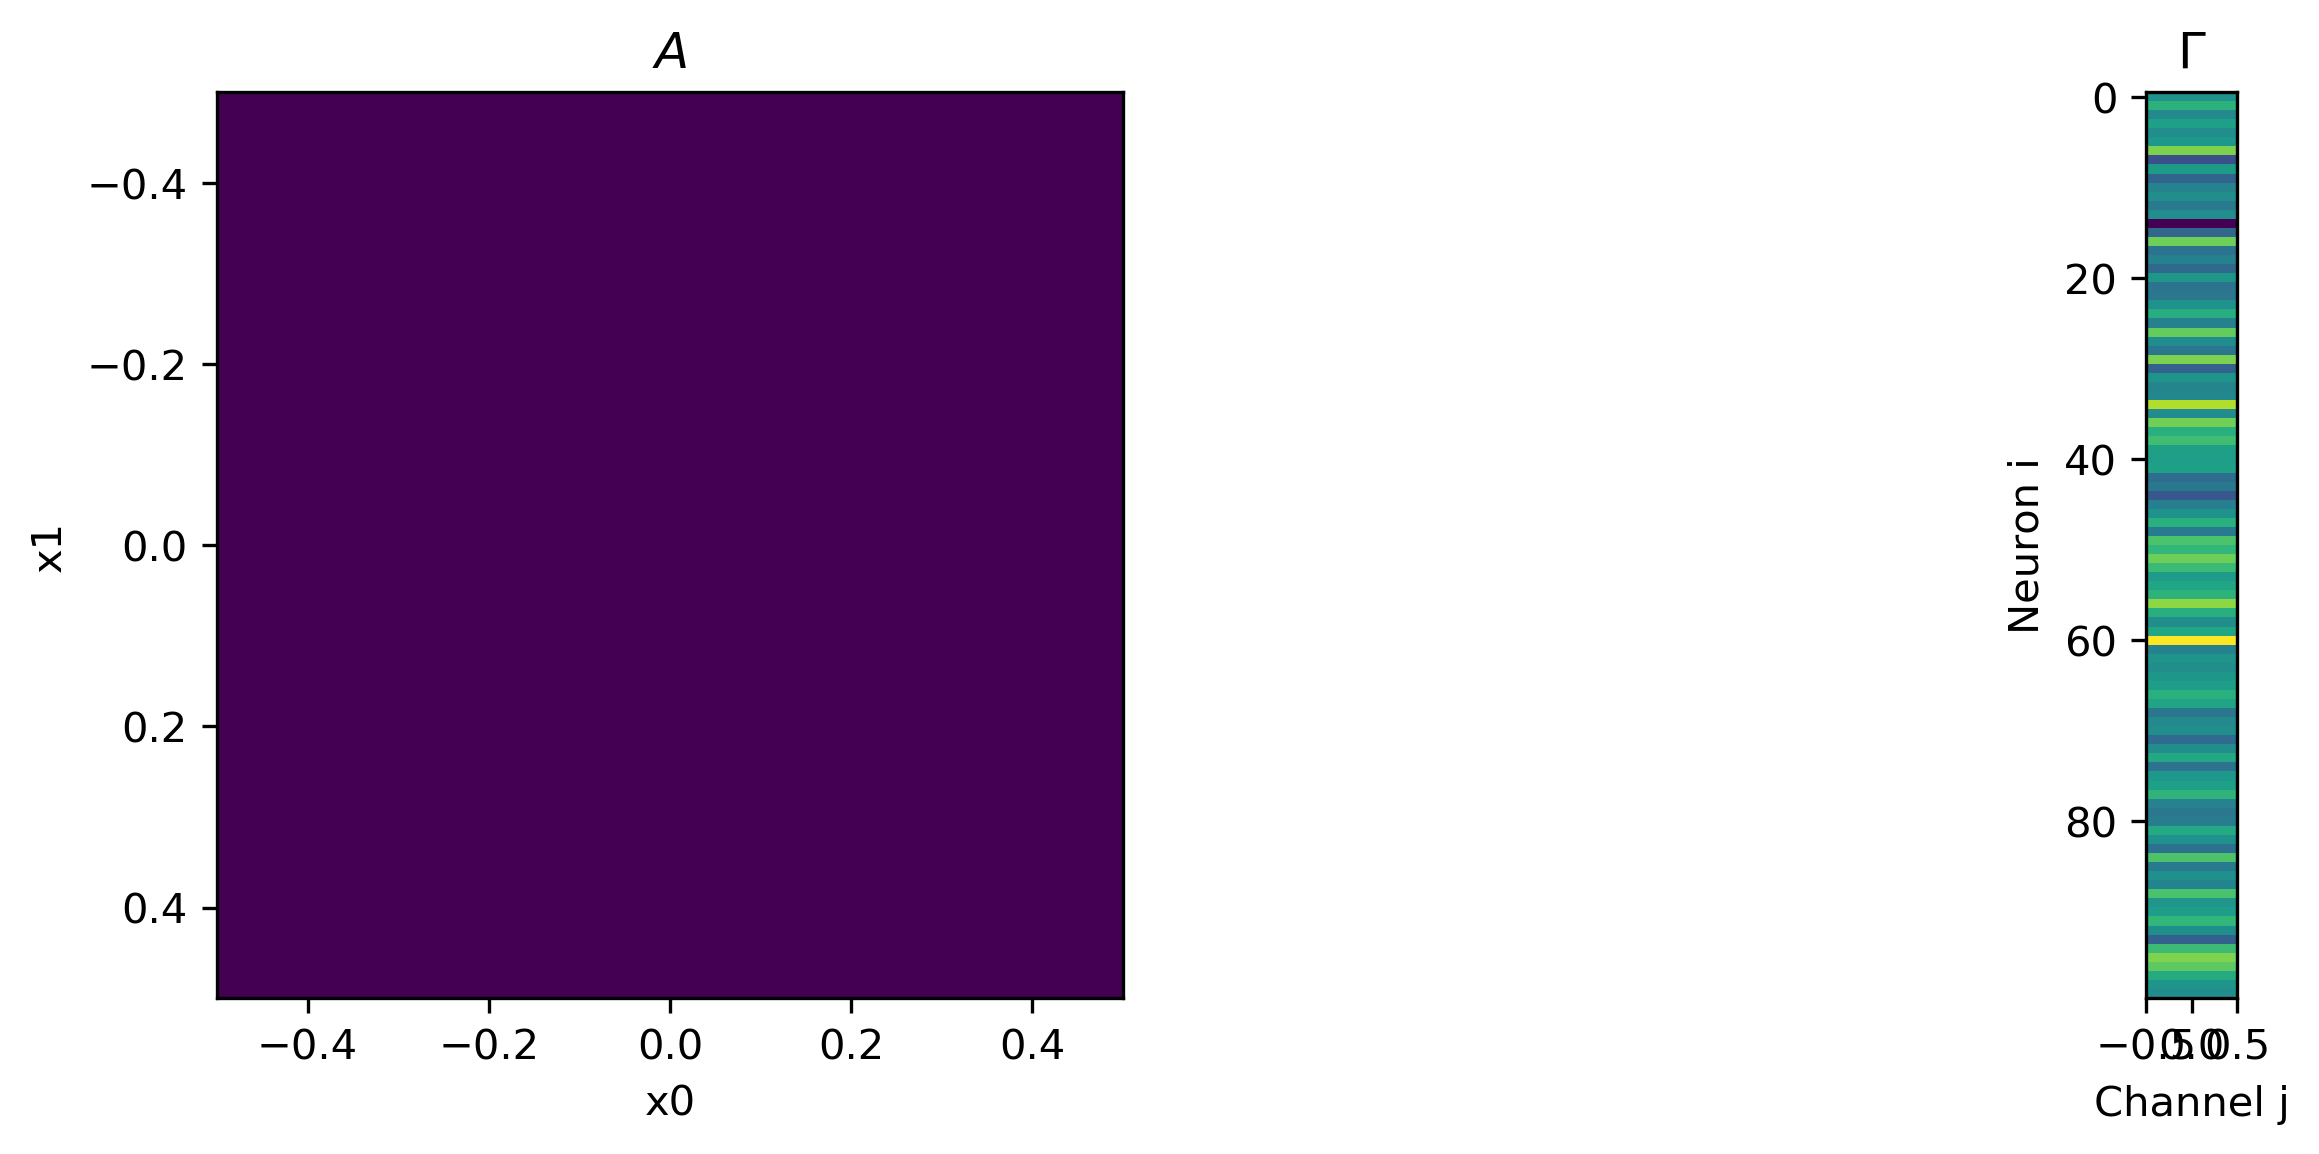

In [2]:
# - Define the dynamical system to be approximated 
nNumVariables = 1
fLambda_s = 1
mfA = -fLambda_s * np.identity(nNumVariables)

# - Generate random decoding weights
nNetSize = 100
mfGamma = np.random.randn(nNumVariables, nNetSize)

# - Plot system matrices
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(mfA)
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('$A$')

plt.subplot(1, 2, 2)
plt.imshow(mfGamma.T, aspect=.1)
plt.xlabel('Channel j')
plt.ylabel('Neuron i')
plt.title('$\Gamma$');

Now we can integrate the dynamical system under a simple command input, and visualise the desired behaviour of the system.

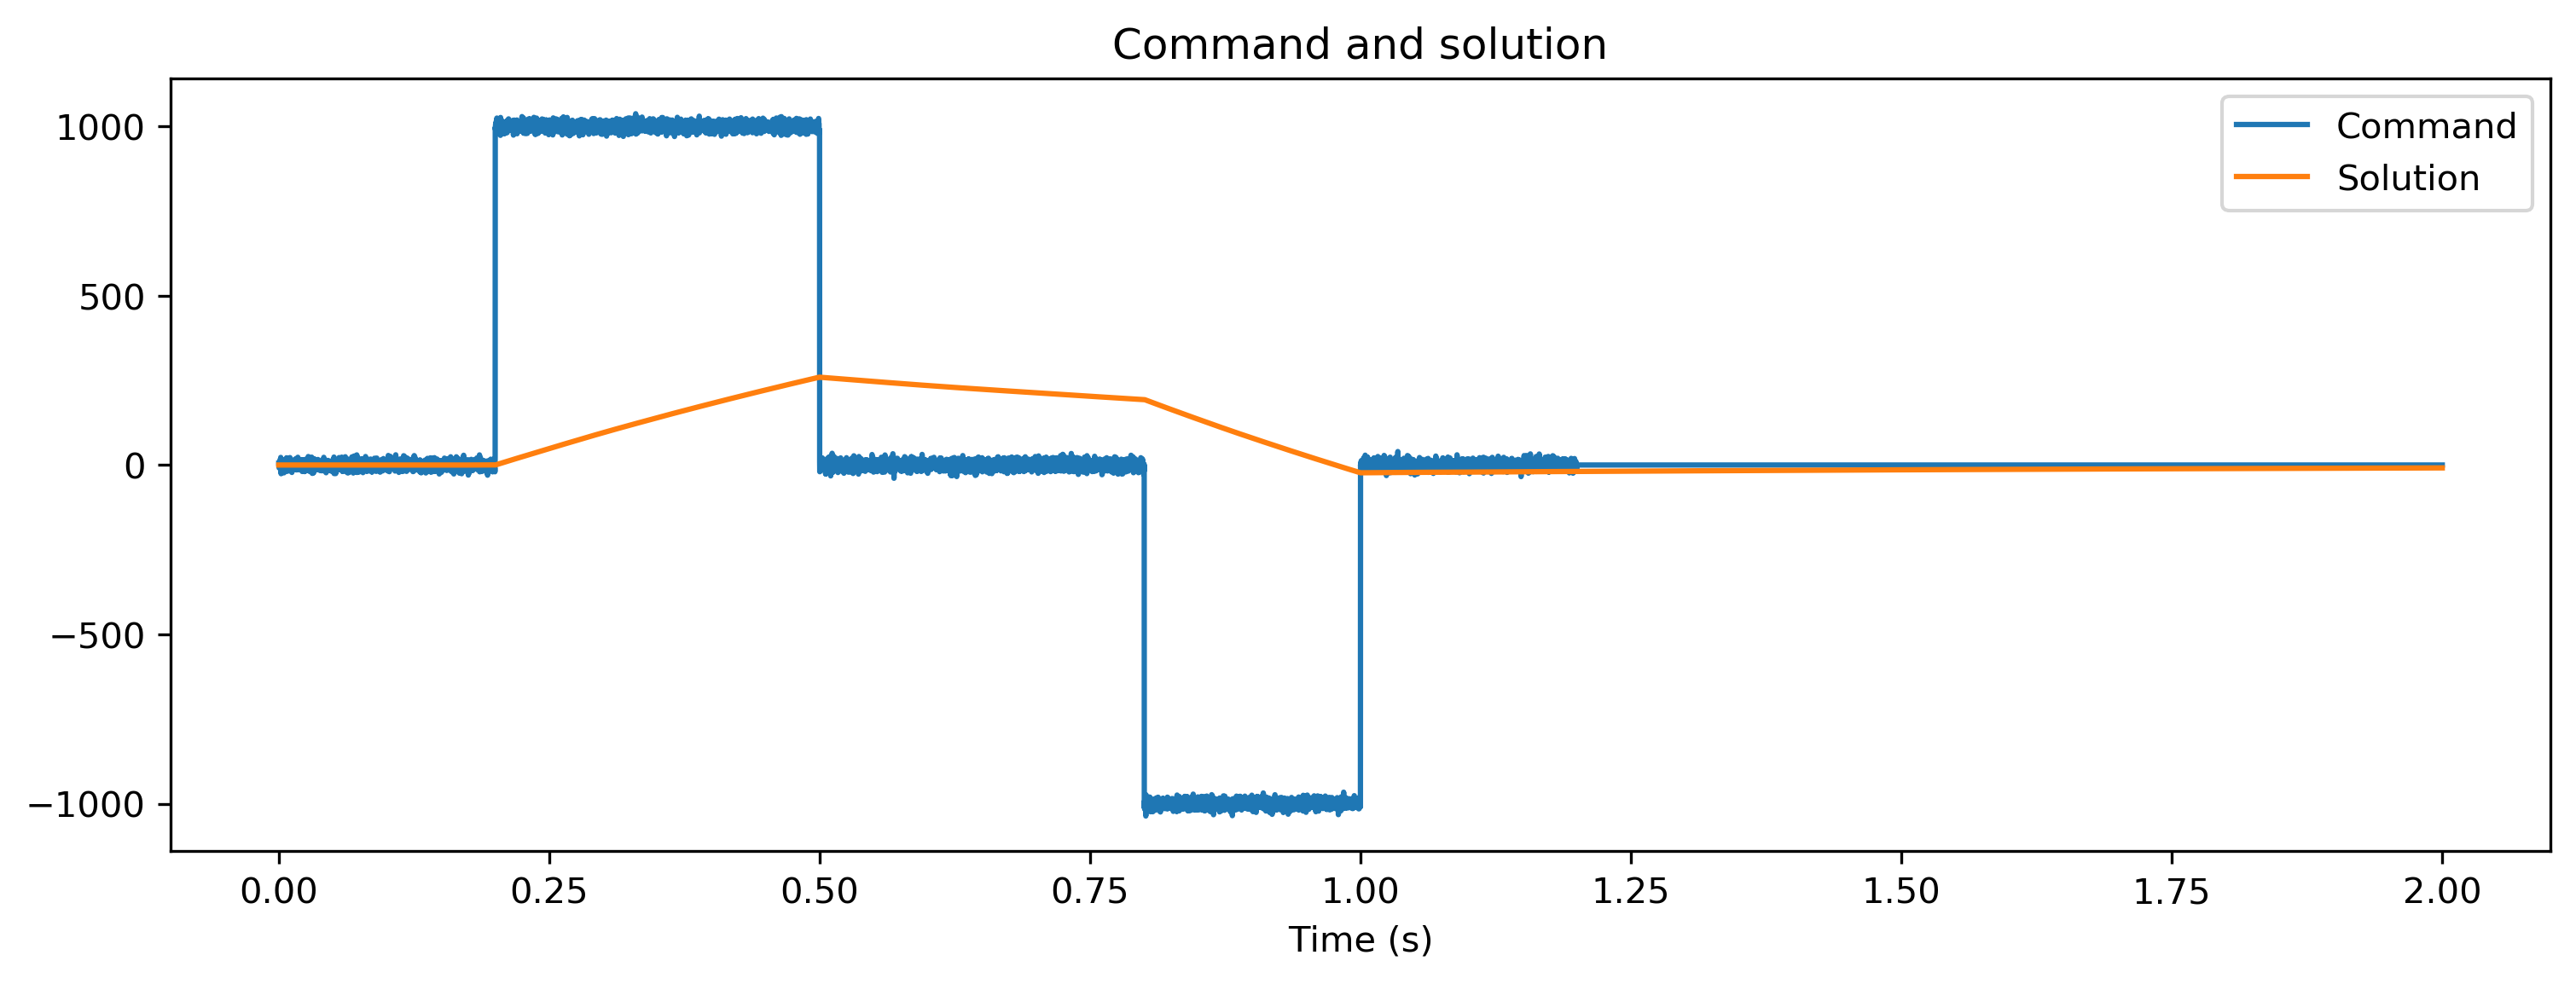

In [3]:
# - Simulate the system under a simple command input 

# - Create a command trace c(t)
fhCommand = lambda t: np.asarray(np.asarray(t)>np.asarray(200e-3), float) * np.asarray(np.asarray(t)<np.asarray(500e-3), float) - \
                      np.asarray(np.asarray(t)>np.asarray(800e-3), float) * np.asarray(np.asarray(t)<np.asarray(1000e-3), float)
tDuration = 2000e-3
fCommandAmp = 1000
fSigmaS = 0.01 * fCommandAmp
tNoiseEnd = 1200e-3
tResCommand = .1e-3
tDt = 0.1e-3
tResSolution = .09e-3
fhNoise = lambda t: np.random.randn(np.size(t)) * fSigmaS * np.asarray(np.asarray(t) < np.asarray(tNoiseEnd))
vtTimeTrace = np.arange(0, tDuration + tResCommand, tResCommand)
vtTimeTraceSol = np.arange(0, tDuration, tResSolution)
tsCommand = TSContinuous(vtTimeTrace, fCommandAmp * fhCommand(vtTimeTrace) + fhNoise(vtTimeTrace),
                       periodic = True, name='Command')

# - Integrate the system
vfX0 = [0]
fhDotX = lambda t, vfX : mfA @ vfX + tsCommand(t)
solODE = solve_ivp(fhDotX, (0, np.asarray(tDuration)), vfX0, method = 'LSODA',
                   t_eval = vtTimeTraceSol)
tsSolution = TSContinuous(solODE.t, np.squeeze(solODE.y.T), periodic = True, name = 'Solution')

# - Display the solution trace
plt.figure()
tsCommand.plot()
tsSolution.plot()
plt.title('Command and solution')
plt.legend();

For the given decoder weights $\mathbf{\Gamma}$ (`mfGamma`) we can also obtain the fast and slow recurrent weights $\mathbf{\Omega}^f$ and $\mathbf{\Omega}^s$. To do so we need to define the remaining parameters $\lambda_d$, $\mu$ and $\nu$. The recurrent weights and thresholds are defined according to the equations above.

The reset potential $\mathbf{V}_\textrm{reset}$ for each neuron is defined by the diagonal of $\mathbf{\Omega}^s$.

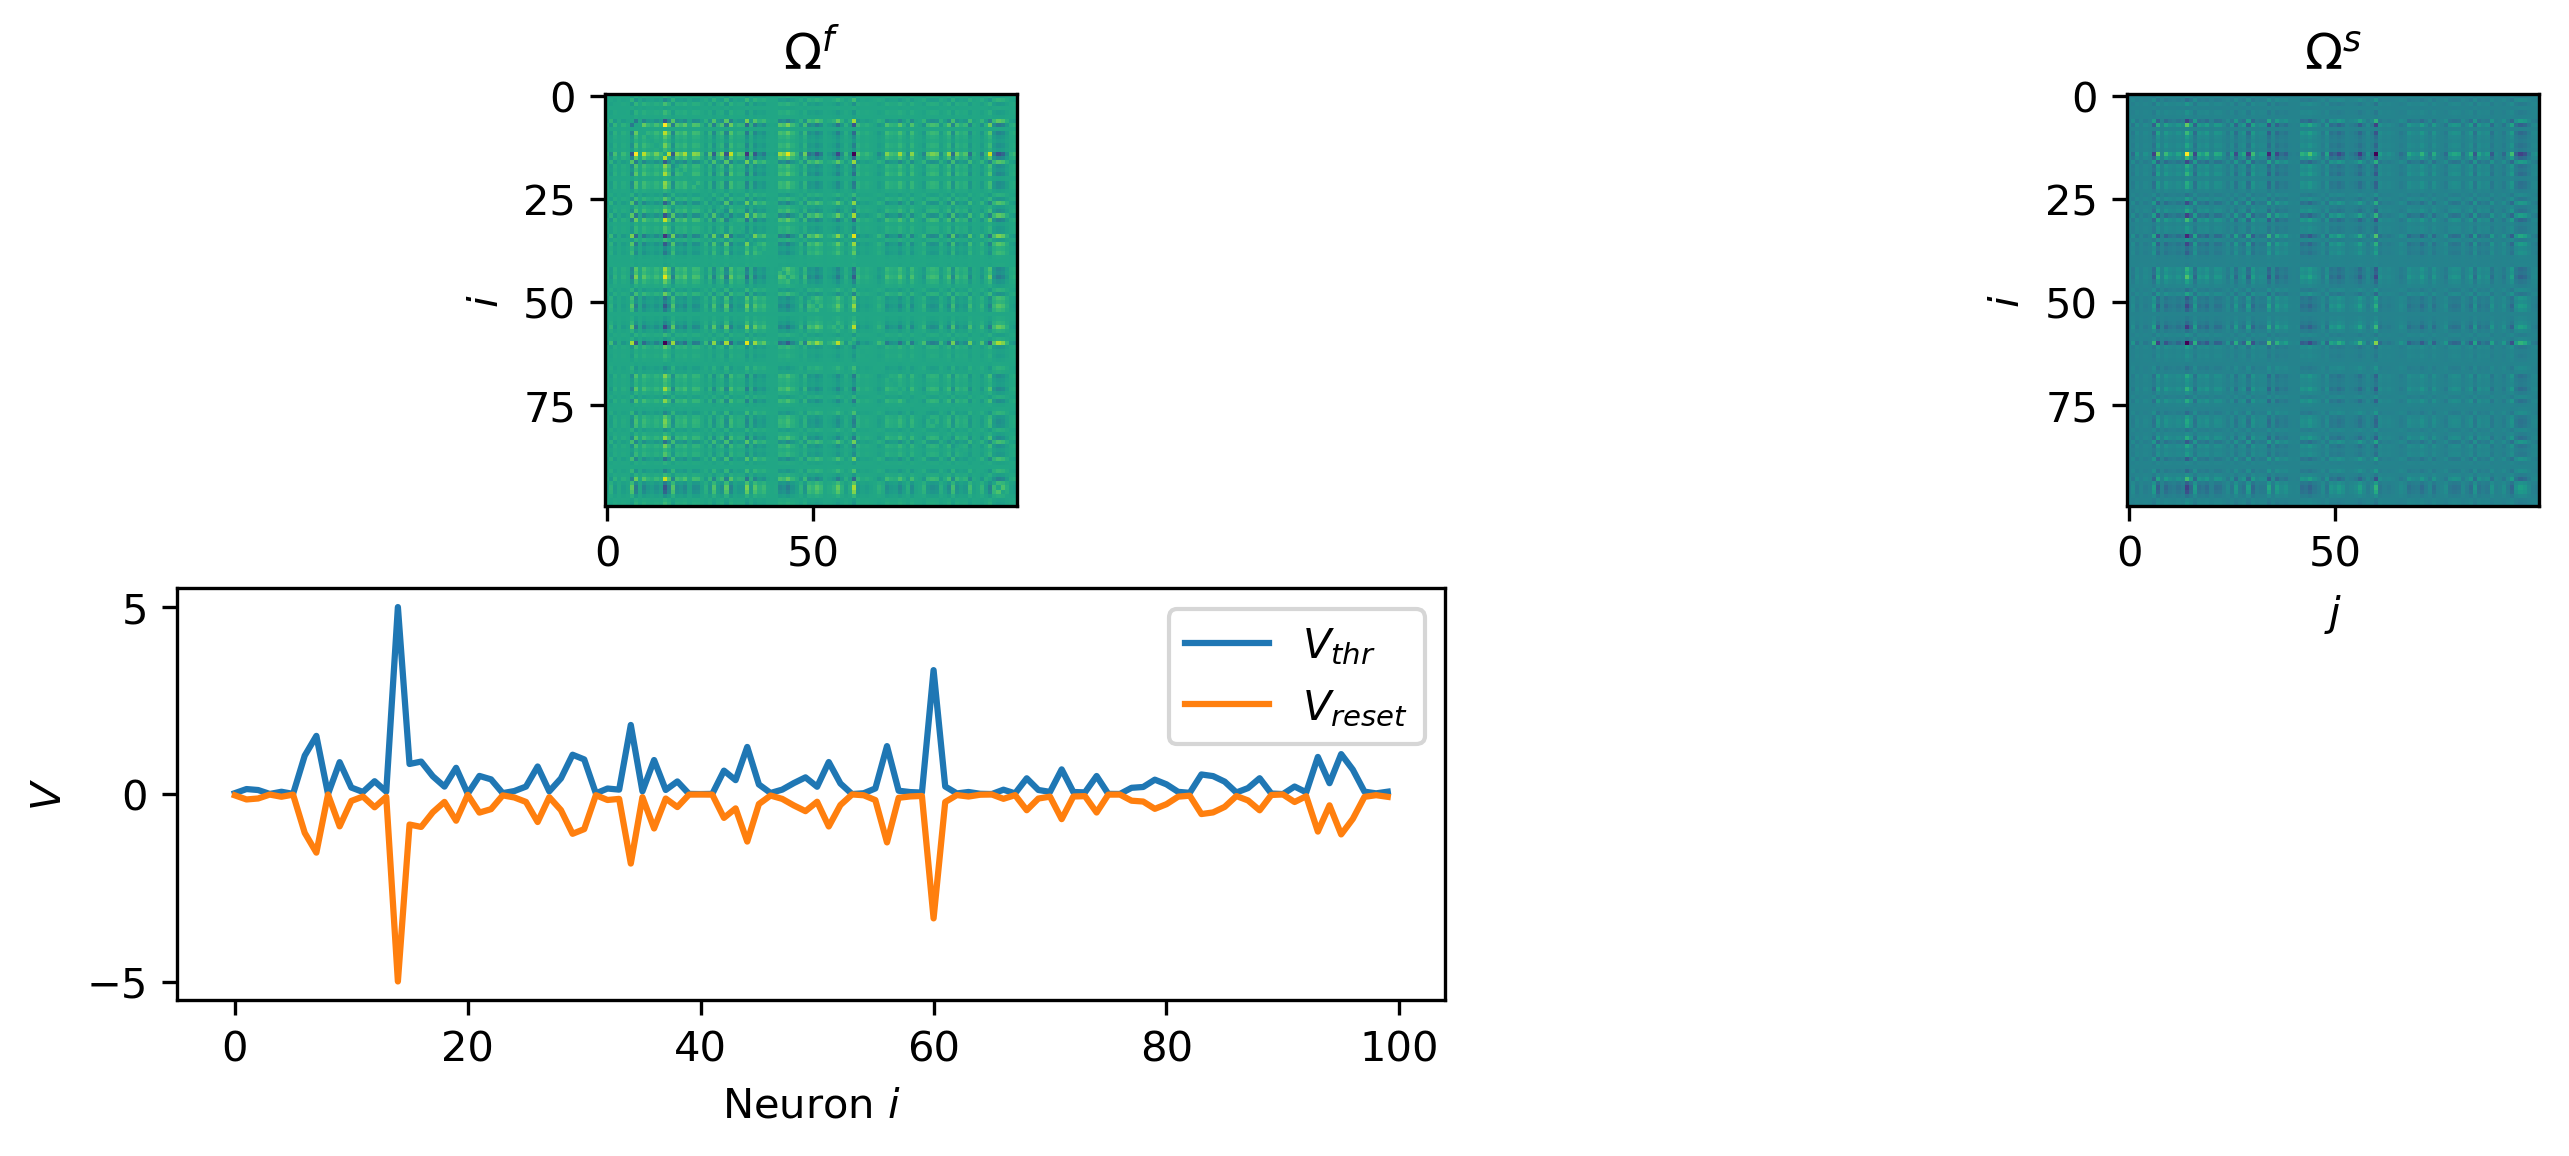

In [4]:
# - Define system parameters 
fLambda_d = 10
fLambda_V = 20
fTauN = 1/fLambda_V
fTauS = 1/fLambda_d
fMu = 1e-4
fNu = 1e-3

# - Determine the fast and slow recurrent weights
mfOmega_f = mfGamma.T @ mfGamma + fMu * fLambda_d**2 * np.identity(nNetSize)
mfOmega_s = mfGamma.T @ (mfA + fLambda_d * np.identity(nNumVariables)) @ mfGamma

# - Determine the firing thresholds
vfT = (fNu * fLambda_d + fMu * fLambda_d**2 + np.sum(abs(mfGamma.T), -1, keepdims = True)**2) / 2

# - Pull out reset voltages
vfV_reset = vfT - np.reshape(np.diag(mfOmega_f), (-1, 1))
np.fill_diagonal(mfOmega_f, 0)

# - Show resulting values
plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(mfOmega_f)
plt.xlabel('$j$')
plt.ylabel('$i$')
plt.title('$\Omega^f$')

plt.subplot(2, 2, 2)
plt.imshow(mfOmega_s)
plt.xlabel('$j$')
plt.ylabel('$i$')
plt.title('$\Omega^s$')

plt.subplot(2, 2, 3)
plt.plot(vfT.flatten())
plt.plot(vfV_reset.flatten())
plt.xlabel('Neuron $i$')
plt.ylabel('$V$')
plt.legend(['$V_{thr}$', '$V_{reset}$']);

The dynamical equations of neurons and synapses are given by

$\tau_N \dot{\mathbf{V}} + \mathbf{V} = \mathbf{V}_\textrm{rest} + \mathbf{I}^f + \mathbf{I}^s + \mathbf{I}^{ext} + \sigma_V \eta(t)$

$V_i > T_i \rightarrow \textrm{spike}_i, V_i = V_\textrm{reset}, i$

$\tau_f \dot{\mathbf{I}}^f + \mathbf{I}^f = 0$

$\tau_s \dot{\mathbf{I}}^s + \mathbf{I}^s = 0$

$\textrm{spike}_i \rightarrow \mathbf{I}^f = \mathbf{I}^f + -\mathbf{\Omega^f}_i, \mathbf{I}^s = \mathbf{I}^s + \mathbf{\Omega^s}_i$

$\mathbf{I}^{ext} = \mathbf{\Gamma}^T\mathbf{c}(t)$

Here we include explicit synaptic dynamics for both fast and slow synaptic connections, mediated by time constants $\tau_f$ and $\tau_s$. This is to be more realistic for hardware implementation; the original system definition in the previous section uses instantaneous synaptic dynamics for fast synapses. The slightly modified dynamics requires scaling of parameters by the neuron and synapse time constants; since the all synaptic input are defined to be positive, $\mathbf{\Omega}^f$ is negated.

In [5]:
# - Construct a spiking reservoir, setting the weights explicitly
dr = NetworkDeneve.SpecifyNetwork(weights_fast = -mfOmega_f * fTauN / 1e-3,
                                  weights_slow = mfOmega_s * fTauN,
                                  weights_in = mfGamma * fTauN,
                                  weights_out = mfGamma.T,
                                  tau_mem = fTauN,
                                  tau_syn_r_fast = 1e-3,
                                  tau_syn_r_slow = fTauS,
                                  tau_syn_out = fTauS,
                                  v_thresh = vfT,
                                  v_rest = vfV_reset,
                                  v_reset = vfV_reset,
                                  noise_std = 0.1,
                                  dt = tDt,
                                 )
dr

NetworkDeneve object with 3 layers
    PassThrough object: "Input" [1 TSContinuous in -> 100 internal -> 100 TSContinuous out]
    RecFSSpikeEulerBT object: "Deneve_Reservoir" [100 TSContinuous in -> 100 internal -> 100 TSEvent out]
    FFExpSyn object: "Output" [100 TSEvent in -> 1 internal -> 1 TSContinuous out]

We can then simulate the dynamical system $\mathbf{A}$ using the reservoir model, by injecting a command input `tsCommand`, and comparing the result against the directly evaluated linear dynamical system. The performance of the model is better with a small amount of membrane noise $\sigma_V>0$ (the parameter `noise_std` to `SpecifyNetwork` above).

Network: Evolving layer `Input` with external input as input
Network: Evolving layer `Deneve_Reservoir` with Input's output as input
extending record length
Network: Evolving layer `Output` with Deneve_Reservoir's output as input


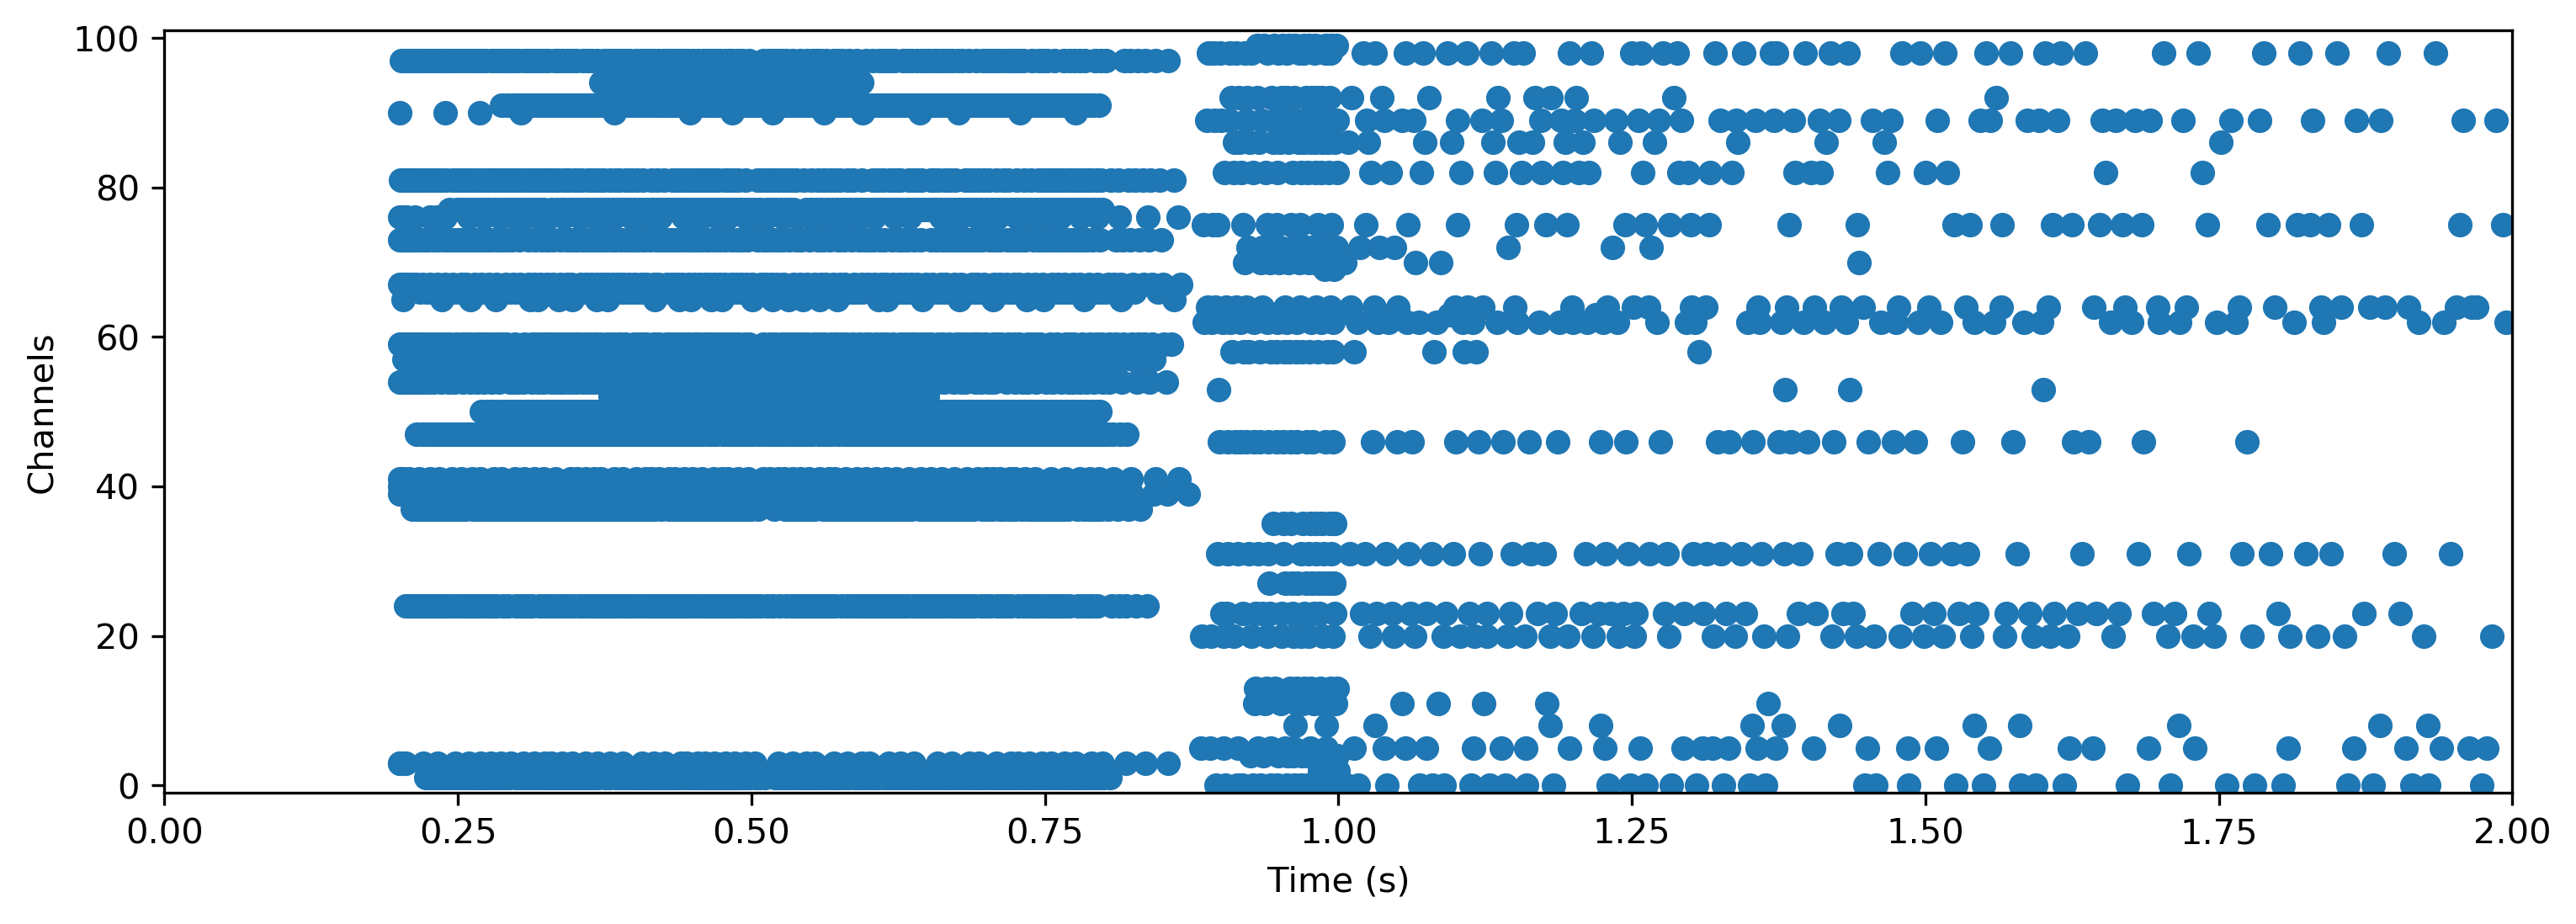

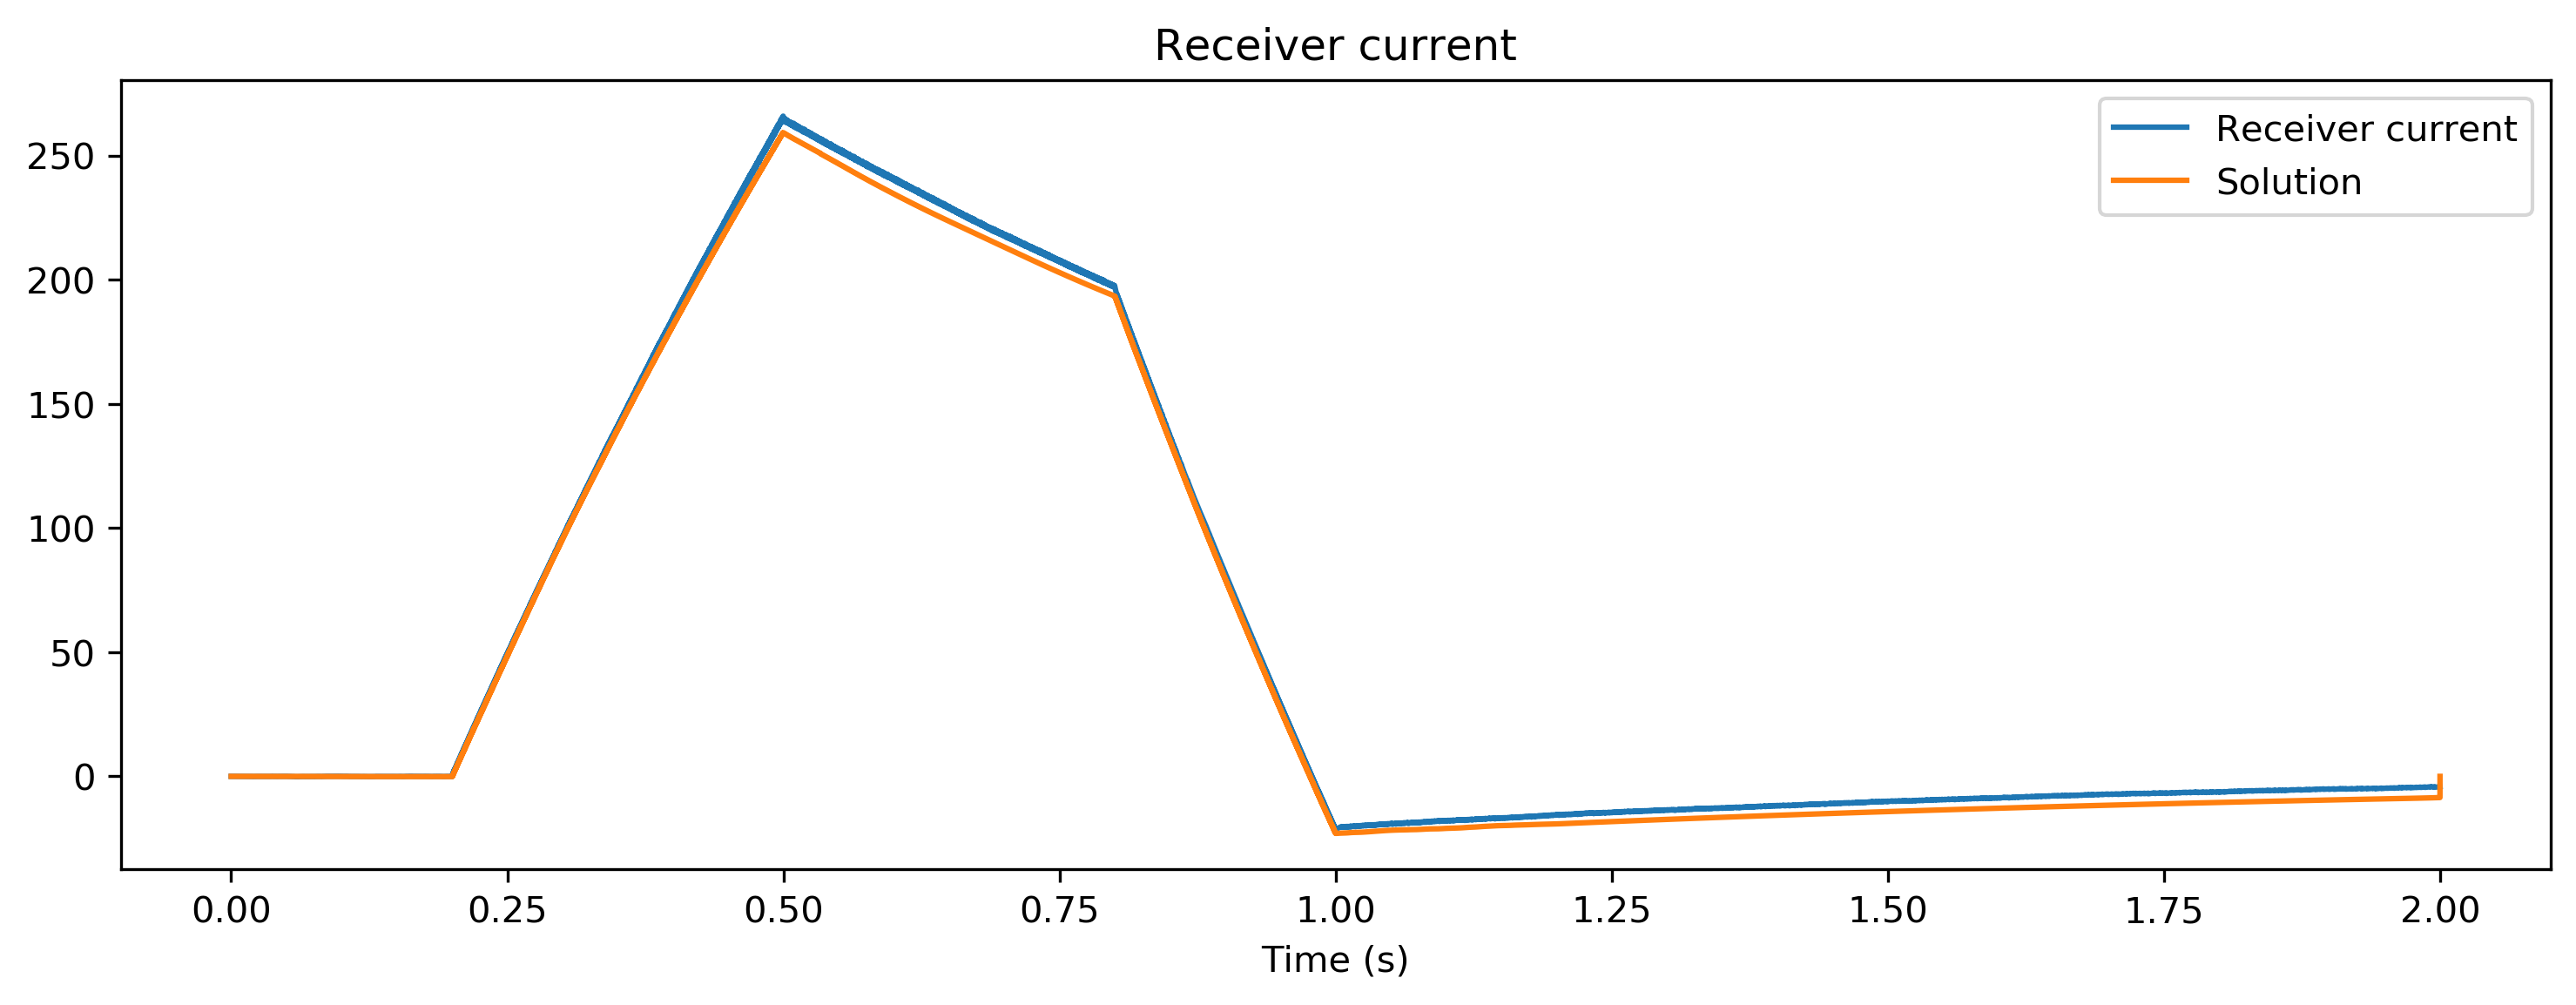

In [6]:
# - Simulate the reservoir
dResp = dr.evolve(tsCommand, tDuration)

# - Plot spikes and output
plt.figure()
dResp['Deneve_Reservoir'].plot()

plt.figure()
dResp['Output'].plot()
tsSolution.plot(dResp['Output'].times)
plt.legend();

## Specifying a dynamical system directly

In this example we will use the system
$\dot{\mathbf{x}} = \mathbf{Ax} + \mathbf{c}(t)\textrm{, where}$

$$ \mathbf{A} = \begin{bmatrix}-400 & -800 \\
50 & 0 \\
\end{bmatrix} $$

In [7]:
# - Specify the system dynamics
nNumVariables = 2
mfA = np.array([[-400, -800], [50, 0]])

# - Construct a reservoir that solves this dynamical system
dr = NetworkDeneve.SolveLinearProblem(a = mfA,
                                      net_size = 100,
                                      noise_std = 0.01,
                                     )
dr

NetworkDeneve object with 3 layers
    PassThrough object: "Input" [2 TSContinuous in -> 100 internal -> 100 TSContinuous out]
    RecFSSpikeEulerBT object: "Deneve_Reservoir" [100 TSContinuous in -> 100 internal -> 100 TSEvent out]
    FFExpSyn object: "Output" [100 TSEvent in -> 2 internal -> 2 TSContinuous out]

In [8]:
# - Specify a new command signal
fCommandAmp = 5000
fSigmaS = 0.01*fCommandAmp
vtTime = np.arange(0, tDuration, 1e-3)
vfCommand = np.zeros((np.size(vtTime), nNumVariables))
vfCommand[np.logical_and(vtTime > 200e-3, vtTime < 500e-3), 0] = 1
vfCommand[np.logical_and(vtTime > 800e-3, vtTime < 1000e-3), 0] = -3
vfCommand *= fCommandAmp
vfCommand[:, 0] += fSigmaS * np.random.standard_normal(np.size(vtTime))

tsCommand = TSContinuous(vtTime, vfCommand, periodic = True, name = 'Command')

# - Integrate the system
vfX0 = [0, 0]
fhDotX = lambda t, vfX : mfA @ vfX + tsCommand(t)
solODE = solve_ivp(fhDotX, (0, np.asarray(tDuration)), vfX0, method = 'LSODA',
                   t_eval = vtTimeTraceSol)

tsSolution = TSContinuous(solODE.t, solODE.y.T, name = 'Solution')

In [9]:
# - Simulate the reservoir
dResp = dr.evolve(tsCommand, tDuration)

Network: Evolving layer `Input` with external input as input
Network: Evolving layer `Deneve_Reservoir` with Input's output as input
extending record length
Network: Evolving layer `Output` with Deneve_Reservoir's output as input


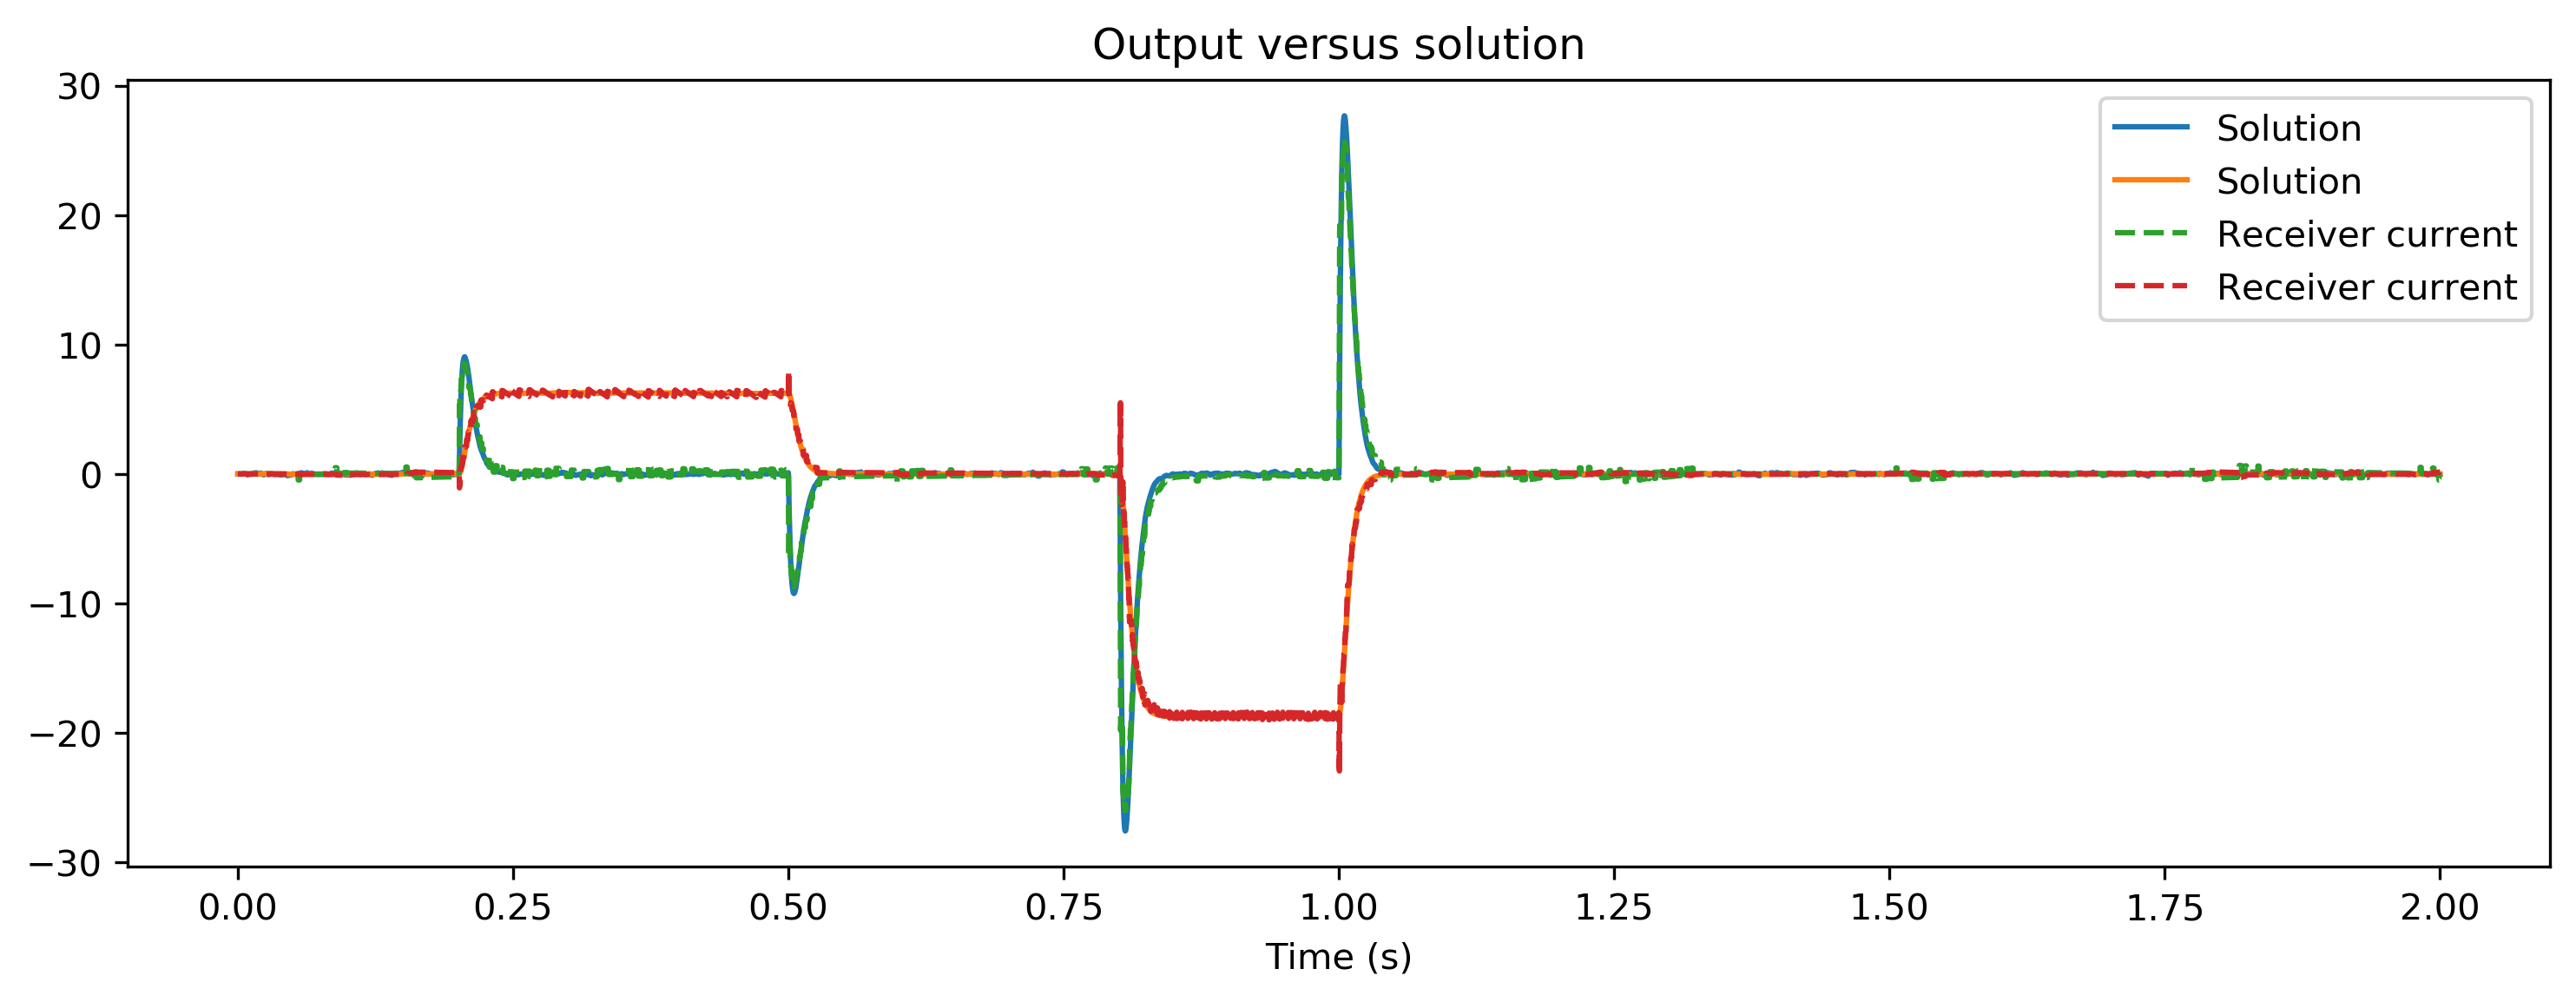

In [10]:
# - Plot reservoir output against integrated solution
plt.figure()
tsSolution.plot()
dResp['Output'].plot(ls='--')
plt.title('Output versus solution')
plt.legend();

The reservoir implementes the specified dynamical system, and errors are low. The reservoir can sometimes struggle to follow extremely fast system dynamics (see for example the spikes close to 750ms and 1000ms in the case above). In this case, you can speed up the fast dynamics inside the reservoir using the ``tau_syn_fast`` parameter to :py:meth:`.SolveLinearProblem`. This is illustrated below.

In [11]:
# - Build and simulate an even faster reservoir
drFast = NetworkDeneve.SolveLinearProblem(a = mfA,
                                          net_size = 100,
                                          tau_syn_fast = .5e-3,
                                          noise_std = 0.01,
                                         )
dRespFast = drFast.evolve(tsCommand, tDuration)

Network: Evolving layer `Input` with external input as input
Network: Evolving layer `Deneve_Reservoir` with Input's output as input
extending record length
Network: Evolving layer `Output` with Deneve_Reservoir's output as input


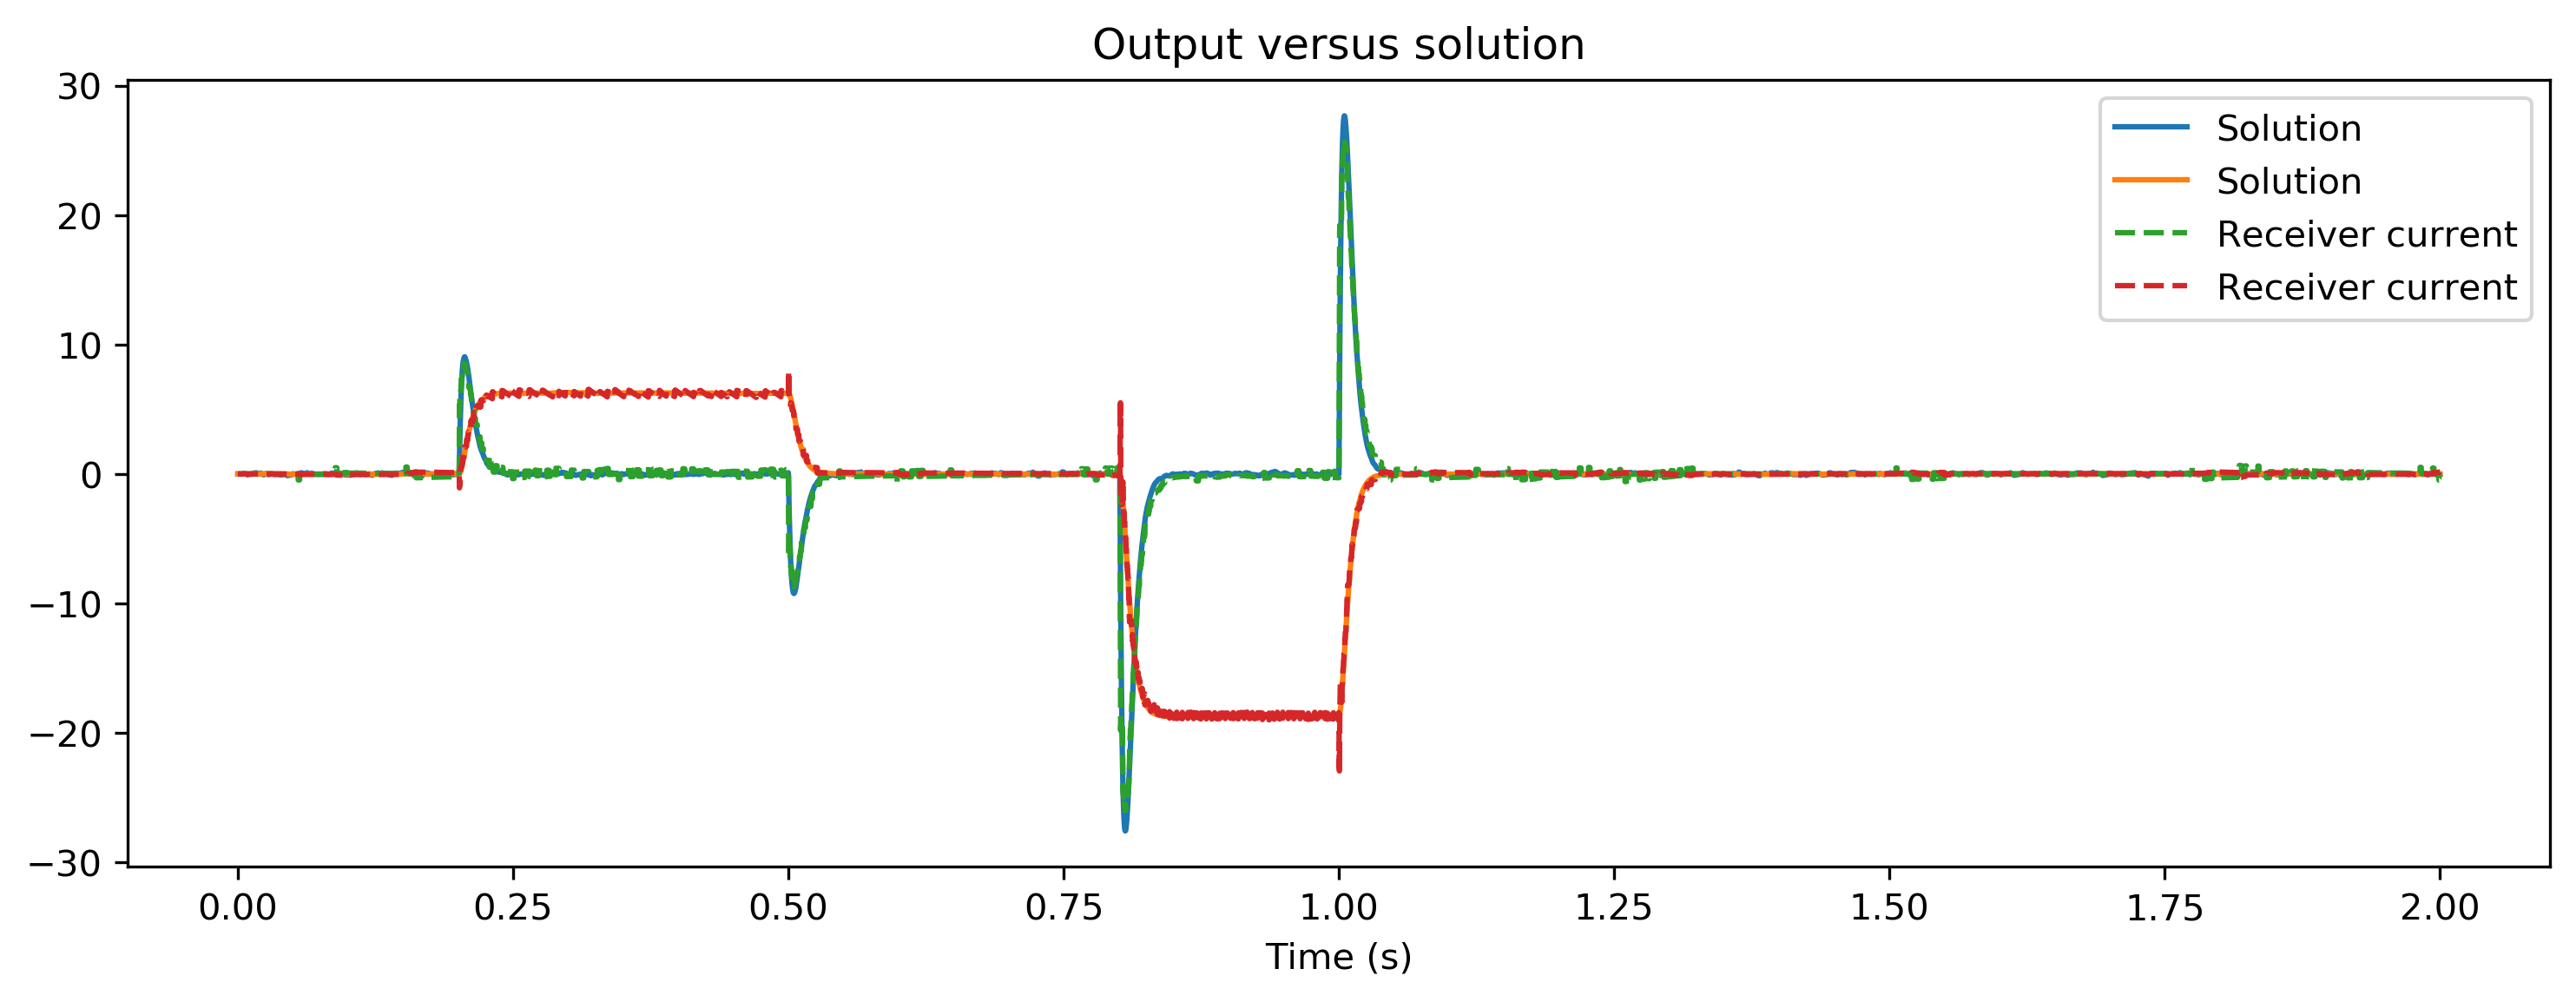

In [12]:
# - Plot reservoir output against integrated solution
plt.figure()
tsSolution.plot()
dResp['Output'].plot(ls='--')
plt.title('Output versus solution')
plt.legend();

## How does it work?
The network receives an external input $\mathbf{c}(t)$, projected into a random high-dimensional space given by $\mathbf{\Gamma}$ (the "input kernels". The network tracks a set of variables $\mathbf{x}$, mapped into the same high dimensional space. The fast feedback provided by $\mathbf{\Omega}^f$ is defined such that neurons with similar input kernels inhibit each other strongly; neurons with differing input kernels excite each other strongly. Fast synaptic feedback therefore provides a loop implementing $-\mathbf{\hat x}$.

Slow synaptic feedback $\mathbf{\Omega}^s$ is defined in the same space $\mathbf{\Gamma}$, but provides an opposing feedback loop implementing $\mathbf{\hat x} + f(\mathbf{\hat x})$. Instead of sending the reservoir output explicitly as an extra input (another possibility), this feedback loop is implemented implicitly through slow synaptic feedback. Slow synaptic feedback also compensates for readout decay $\lambda_d$ and $\tau_d$.

As a result, the network tracks $\mathbf{c}(t) + \left[ \mathbf{\hat x} + f(\mathbf{\hat x})\right] + \left[-\mathbf{\hat x}\right] = f(\mathbf{\hat x}) + \mathbf{c}(t)$. Here $f(\mathbf{\hat x})$ is an arbitrary function acting as a transformation of the hidden variables $\mathbf{x}$. In the cases explored here, $f(\mathbf{\hat x})$ implements a linear dynamical system $\mathbf{A}$; however this function can in principal be nonlinear and arbitrary. In the linear dynamical systems case, slow recurrent weights $\mathbf{\Omega}^s$ can be determined analytically. In more complex cases this weight structure must be learned. This will be explored in following technical reports.

The structure of the thresholds $\mathbf{T}$ ensures that neurons only fire when they decrease the error $\mathbf{x} - \mathbf{\hat x}$. Via the neurons reset potentials $\mathbf{V}_\textrm{reset}$, instantaneous "inhibtory feedback" ensures that spikes are distributed evenly using the quadratic cost term $\mu$.

## Summary table of parameters and definitions

| Parameter         | Description                              |
| ----------------- | ---------------------------------------- |
| $J$               | Size of input vector                     |
| $N$               | Number of neurons in reservoir            |
| $\mathbf x$       | Dynamical system state ($J$ elements)    |
| $\mathbf{\hat x}$ | Network's estimate of dynamical system state ($J \times 1$) |
| $\mathbf A$       | State transition matrix of dynamical system ($J\times J$) |
| $\mathbf{c}(t)$   | External input ($J \times 1$)            |
| $\mathbf{o}_i(t)$ | Spike train of neuron $i$                |
| $r_i(t)$          | Firing rate of neuron $i$                |
| $\lambda_d$, $\tau_d$ | Time constant of decay for output synapse decoding |
| $\mu$             | Quadratic cost term (distribute spikes evenly) |
| $\nu$             | Linear cost term (minmise number of spikes) |
| $T_i$             | Spiking threshold of neuron $i$          |
| $\mathbf{\Gamma}$ | Input and decoding weights ($J\times N$) |
